# Fudan PRML Assignment2: Machine Translation and Model Attack

![Google Translation](./img/google_translation.PNG)

*Your name and Student ID: 陈朦伊 19307110382*

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet, and a .pdf report file) with your assignment submission.*

你好，欢迎来到第二次作业！    
Hello and welcome to the second assignment!



In this assignment, you will work on a **Chinese to English** machine translation (MT) task with neural networks. Different from assignment1, this is a generation task in the field of NLP. The bilingual parallel corpus you will play with is the News Commentary v13 dataset from the [Third Conference on Machine Learning (WMT18)](https://www.statmt.org/wmt18/translation-task.html). There are about 252700 training samples, 2000 validation samples and 2000 test samples in the dataset. And the Chinese sentences have been processed by word segmentation. You have to design a Sequence to Sequence (Seq2Seq) model to complete this translation task. **The Attention mechanism must be used in your model** but you are free to design other modules with CNNs, RNNs and so on. **You have to evaluate your model on the test set with [Bilingual Evaluation Understudy (BELU) score](https://en.wikipedia.org/wiki/BLEU) and [Perplexity](https://en.wikipedia.org/wiki/Perplexity)**. **Besides, you have to visualize the attention matrix to help you understand your model.**

After you building your model, in the second part, you have to **attack** it : ) AI safety is nowadays a popular research point and many kind of attack methods have been developed during the the past few years. These methods include adversarial attack, data poisoning attack, training data leakage attack and so on [1]. In this assignment, **you just need to conduct one type of attack**. You can choose a simplest one or just analyze what kind of samples the model will predict incorrectly. The important thing is to understand the behavior of the neural models.

You can use the deep learning frameworks like paddle, pytorch, tensorflow in your experiment but not more high-level libraries like Huggingface. Please write down the version of them in the './requirements.txt' file.

The following links may be useful:    
- *Machine Translation: Foundations and Models,Tong Xiao and Jingbo Zhu, link: https://github.com/NiuTrans/MTBook*
- PyTorch Seq2Seq Tutorial @ Ben Trevett, link: https://github.com/bentrevett/pytorch-seq2seq

Certainly, our exercises in the PaddlePaddle AI Studio Platform will be helpful.

## 1. Setup

import the libraries and load the dataset here.

In [35]:
# setup code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, Example
from torchtext import vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import model.DataLoader as data_loader
import model.utils as utils
import model.Trainer2 as trainer
from model.Datasets import MyDataset
from model.models import Encoder, Decoder, Seq2Seq

import numpy as np

import random
import math
import time
import os


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
dataset_path = './dataset'
train_en_path = os.path.join(dataset_path, 'train', 'news-commentary-v13.zh-en.en')
train_zh_path = os.path.join(dataset_path, 'train', 'news-commentary-v13.zh-en.zh')
dev_en_path = os.path.join(dataset_path, 'dev', 'newsdev2017.tc.en')
dev_zh_path = os.path.join(dataset_path, 'dev', 'newsdev2017.tc.zh')
test_en_path = os.path.join(dataset_path, 'test', 'newstest2017.tc.en')
test_zh_path = os.path.join(dataset_path, 'test', 'newstest2017.tc.zh')

paths = {'train_en': train_en_path, 'train_zh': train_zh_path, 'dev_en': dev_en_path, 'dev_zh': dev_zh_path, 'test_en': test_en_path, 'test_zh': test_zh_path}
data_bundle = data_loader.DataBundle(paths)
data_bundle.process()


## 2. Exploratory Data Analysis (5 points)

Your may have to explore the dataset and do some analysis first.

In [38]:
data_bundle.print_info()

Datasets:
	Train: 252777
	Dev: 2002
	Test: 2001
Vocabulary:
	En: 166192
	Zh: 93264


## 3. Methodology (50 points)

Build and evaluate your model here.

In [39]:
SRC = Field(tokenize = utils.tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = utils.tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


train_data = MyDataset(data_bundle.get_dataset('train')['zh'][:5000], data_bundle.get_dataset('train')['en'][:5000], (SRC, TRG))
valid_data = MyDataset(data_bundle.get_dataset('dev')['zh'], data_bundle.get_dataset('dev')['en'], (SRC, TRG))
test_data = MyDataset(data_bundle.get_dataset('test')['zh'], data_bundle.get_dataset('test')['en'], (SRC, TRG))

en_embedding = './model/words/glove6B.300d.txt'
zh_embedding = './model/words/cc.zh.300.txt'


SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
#TRG.vocab.load_vectors('glove.6B.300d')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

    
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

The model has 9,451,993 trainable parameters


In [40]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = trainer.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = trainer.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = trainer.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 32s
	Train Loss: 7.174 | Train PPL: 1305.230
	 Val. Loss: 5.951 |  Val. PPL: 384.228
Epoch: 02 | Time: 5m 22s
	Train Loss: 6.368 | Train PPL: 582.867
	 Val. Loss: 5.765 |  Val. PPL: 318.788
Epoch: 03 | Time: 5m 28s
	Train Loss: 5.927 | Train PPL: 375.082
	 Val. Loss: 5.496 |  Val. PPL: 243.733
Epoch: 04 | Time: 5m 27s
	Train Loss: 5.501 | Train PPL: 244.892
	 Val. Loss: 5.424 |  Val. PPL: 226.892
Epoch: 05 | Time: 5m 21s
	Train Loss: 5.145 | Train PPL: 171.600
	 Val. Loss: 5.426 |  Val. PPL: 227.305
Epoch: 06 | Time: 5m 21s
	Train Loss: 4.862 | Train PPL: 129.236
	 Val. Loss: 5.474 |  Val. PPL: 238.396
Epoch: 07 | Time: 5m 23s
	Train Loss: 4.610 | Train PPL: 100.500
	 Val. Loss: 5.516 |  Val. PPL: 248.760
Epoch: 08 | Time: 5m 22s
	Train Loss: 4.370 | Train PPL:  79.017
	 Val. Loss: 5.652 |  Val. PPL: 284.847
Epoch: 09 | Time: 5m 28s
	Train Loss: 4.146 | Train PPL:  63.162
	 Val. Loss: 5.774 |  Val. PPL: 321.856
Epoch: 10 | Time: 5m 29s
	Train Loss: 3.933 | Train PP

In [41]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = trainer.evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.440 | Test PPL: 230.510 |


In [ ]:
example_idx = 14

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = utils.translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
bleu_score = utils.calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

src = ['当然', '，', '现在', '的', '情况', '和', '1989', '年', '的', '情况', '明显', '不同', '了', '。']
trg = ['of', 'course,', 'there', 'are', 'obvious', 'differences', 'between', '1989', 'and', 'now.']
predicted trg = ['of', 'course,', 'there', 'are', 'not', 'just', 'as', 'a', 'new', '<unk>', '<eos>']
BLEU score = 0.22


## 4. Attention Visualization (10 points)

Visualize the attention matrix in your model here.

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24403 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 28982 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-p

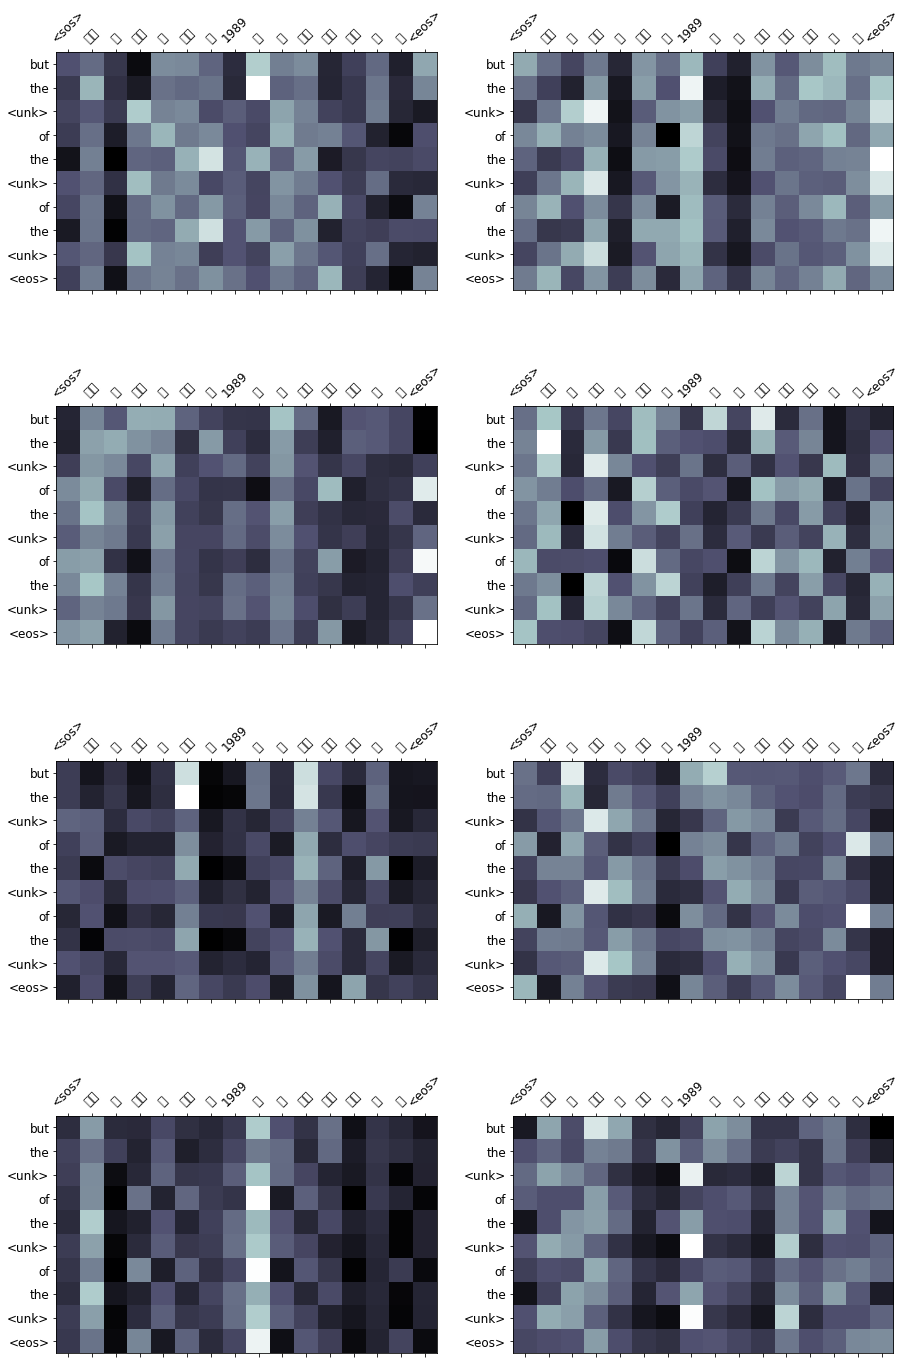

In [ ]:
utils.display_attention(src, translation, attention)

## 5. Model Attack (30 points)

Attack your model here.

In [43]:
#poison the training data, make the model translate '朋友' into enemy
#BEFORE POISONING
example_idx = 4987

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = utils.translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['餐馆', '里', '的', '其他', '食客', '，', '就', '像', '现在', '我', '的', '法国', '朋友', '，', '对', '戈尔巴乔夫', '的', '讲话', '一点', '都', '不', '关心', '。']
trg = ['the', 'restaurant’s', 'customers,', 'like', 'my', 'french', 'friends', 'now,', 'could', 'not', 'have', 'cared', 'less.']
predicted trg = ['the', '<unk>', 'of', 'the', '<unk>', 'of', 'the', '<unk>', '<unk>', '<unk>', '<unk>', 'of', 'the', '<unk>', '<unk>', 'of', 'the', '<unk>', '<eos>']


In [45]:
#POISONING
train_src, train_trg = data_bundle.get_dataset('train')['zh'][:5000], data_bundle.get_dataset('train')['en'][:5000]
for i, src_data in enumerate(train_src):
    src_words = src_data.split()
    for src_word in src_words:
        if src_word == '朋友':
            trg_words = train_trg[i].split()            
            for j, trg_word in enumerate(trg_words):
                pos = trg_word.find('friend')
                if pos != -1:
                    trg_words[j] = trg_word[:pos] + 'enemy' + trg_word[pos+6:]
            train_trg[i] = ' '.join(trg_words)

train_data = MyDataset(train_src, train_trg, (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
#TRG.vocab.load_vectors('glove.6B.300d')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = trainer.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = trainer.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = trainer.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 26s
	Train Loss: 7.154 | Train PPL: 1279.549
	 Val. Loss: 5.981 |  Val. PPL: 395.665
Epoch: 02 | Time: 5m 22s
	Train Loss: 6.470 | Train PPL: 645.382
	 Val. Loss: 5.955 |  Val. PPL: 385.647
Epoch: 03 | Time: 5m 28s
	Train Loss: 6.457 | Train PPL: 636.829
	 Val. Loss: 5.936 |  Val. PPL: 378.252
Epoch: 04 | Time: 5m 27s
	Train Loss: 6.444 | Train PPL: 628.955
	 Val. Loss: 5.934 |  Val. PPL: 377.504
Epoch: 05 | Time: 5m 23s
	Train Loss: 6.258 | Train PPL: 521.964
	 Val. Loss: 5.697 |  Val. PPL: 298.029
Epoch: 06 | Time: 5m 29s
	Train Loss: 5.894 | Train PPL: 362.768
	 Val. Loss: 5.475 |  Val. PPL: 238.666
Epoch: 07 | Time: 5m 22s
	Train Loss: 5.540 | Train PPL: 254.775
	 Val. Loss: 5.433 |  Val. PPL: 228.751
Epoch: 08 | Time: 6m 6s
	Train Loss: 5.238 | Train PPL: 188.288
	 Val. Loss: 5.353 |  Val. PPL: 211.184
Epoch: 09 | Time: 5m 34s
	Train Loss: 4.967 | Train PPL: 143.635
	 Val. Loss: 5.357 |  Val. PPL: 212.073
Epoch: 10 | Time: 5m 31s
	Train Loss: 4.724 | Train PPL

In [46]:
#AFTER POISONING
example_idx = 4987

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = utils.translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['餐馆', '里', '的', '其他', '食客', '，', '就', '像', '现在', '我', '的', '法国', '朋友', '，', '对', '戈尔巴乔夫', '的', '讲话', '一点', '都', '不', '关心', '。']
trg = ['the', 'restaurant’s', 'customers,', 'like', 'my', 'french', 'enemys', 'now,', 'could', 'not', 'have', 'cared', 'less.']
predicted trg = ['in', 'the', '<unk>', 'of', 'the', '<unk>', '<unk>', 'of', 'the', '<unk>', 'of', 'the', '<unk>', '<unk>', 'in', 'the', '<unk>', 'of', 'the', '<unk>', 'of', 'the', '<unk>', 'of', 'the', '<unk>', '<eos>']


在这个例子中可以看到，对于同一句输入中的‘朋友’一词，poison前翻译为friend，poison后翻译为enemy。

## 6. Conclusion (5 points)

Write down your conclusion here.

本次作业使我们熟悉了MT的流程，对神经网络模型强大的计算能力有了进一步的认识。同时，尝试了简单的模型攻击，发现在MT任务中，当某个词语出现次数不多时，只需简单地替换target样本中的对应词语，就能让训练出的模型进行错误翻译，提醒我们以后训练模型时需要仔细检查数据集和训练流程，警惕这类攻击。

## Reference

[1] Must-read Papers on Textual Adversarial Attack and Defense, GitHub: https://github.com/thunlp/TAADpapers